In [131]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
# Import normalization modules
from sklearn.preprocessing import MinMaxScaler
# Import machine learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Import model selection module
from sklearn.model_selection import GridSearchCV
# Import the evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# Import the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
credit_info = pd.read_csv("creditcard.csv")

In [31]:
# Shuffle data
credit_info_shuffled = credit_info.sample(frac=1)
# one-hot encode the target variable
#credit_info_encoded = pd.get_dummies(credit_info_shuffled, columns=["Class"])

# Splitting the data into train and test
training_size = int(0.8 * len(credit_info_shuffled))
Training_set = credit_info_shuffled.iloc[:training_size, :]
Test_set = credit_info_shuffled.iloc[training_size:, :]
# Separate out the input variables and the target variables
X_train = Training_set.iloc[:, :-1]
y_train = Training_set.iloc[:, -1]
X_test = Test_set.iloc[:, :-1]
y_test = Test_set.iloc[:, -1]
# min-max normalize the data using MinMaxScaler
normalizer = MinMaxScaler()
X_train_scaled = normalizer.fit_transform(X_train)
X_test_scaled = normalizer.transform(X_test)

# Come up with the fraud weighting
fraud_ratio = len(credit_info[credit_info["Class"] == 1]) / len(credit_info)
fraud_weight = 1/ fraud_ratio * 1.2

In [4]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [5]:
y_train.value_counts()/len(y_train)

0    0.99824
1    0.00176
Name: Class, dtype: float64

In [6]:
y_test.value_counts()/len(y_test)

0    0.998402
1    0.001598
Name: Class, dtype: float64

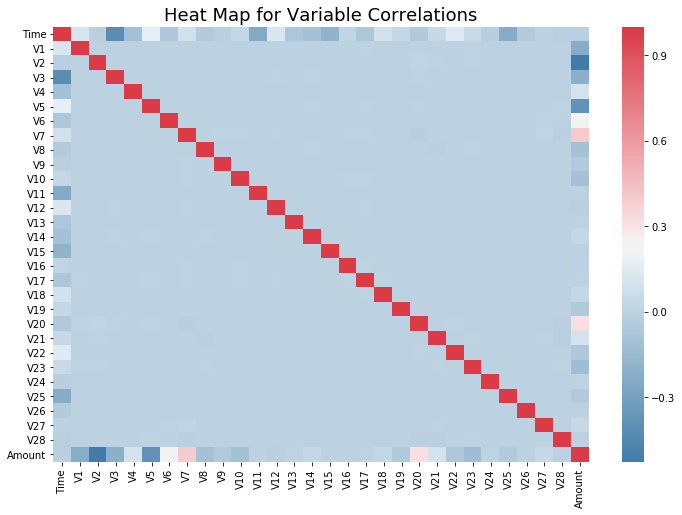

In [7]:
plt.subplots(figsize=(12,8))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(X_train_scaled.corr(), cmap = cmap)
plt.title("Heat Map for Variable Correlations", size = 18)
plt.show()

In [8]:
# Let's show again how each variables are correlated to the target variable
# I will take the absolute value of the pearson correlation coefficient 
variable_to_target_correlations = []
for var in X_train_scaled.columns:
    variable_to_target_correlations.append(abs(pearsonr(X_train_scaled.loc[:,var], y_train)[0]))

In [9]:
var_to_target_cor = pd.Series(variable_to_target_correlations, index=X_train_scaled.columns).sort_values(ascending=False)

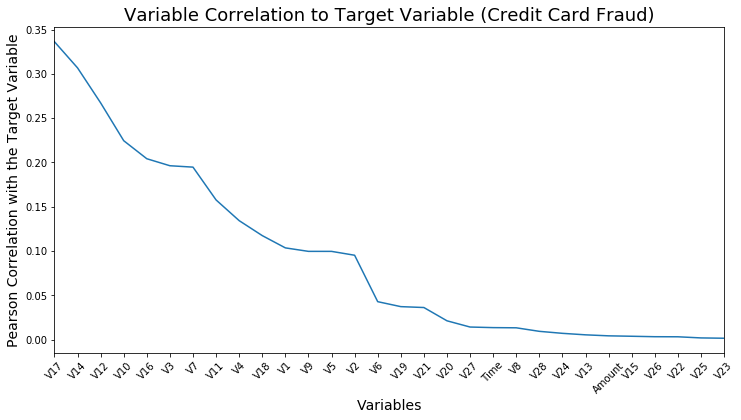

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
pd.Series(var_to_target_cor).sort_values(ascending=False).plot()
ax.set_xticks(range(len(var_to_target_cor)))
ax.set_xticklabels([item for item in var_to_target_cor.index.tolist()], rotation=45)
plt.title("Variable Correlation to Target Variable (Credit Card Fraud)", size=18)
ax.set_ylabel("Pearson Correlation with the Target Variable", size = 14)
ax.set_xlabel("Variables", size = 14)
plt.show()

In [11]:
X_train_scaled.iloc[:,0]

0         0.816589
1         0.753513
2         0.158769
3         0.176739
4         0.970236
            ...   
227840    0.734328
227841    0.915841
227842    0.297086
227843    0.460583
227844    0.118443
Name: Time, Length: 227845, dtype: float64

Some of the variables are weakly correlated with each other, but none are strongly correlated with the target variables

In [22]:
# Let's use random forest to get some ideas about feature importance
rf = RandomForestClassifier(random_state = 0, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [23]:
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)

In [26]:
feature_importance.sort_values(ascending=False)

V14       0.131816
V17       0.130865
V12       0.130096
V10       0.103991
V16       0.082819
V11       0.071992
V9        0.033436
V18       0.027293
V7        0.025307
V4        0.022925
V26       0.021469
V21       0.017321
V6        0.014493
V1        0.014475
V3        0.013743
Time      0.013054
V19       0.011846
V5        0.011698
V27       0.011489
V8        0.011283
V2        0.011256
V20       0.011194
V13       0.010723
Amount    0.010521
V15       0.010475
V22       0.009811
V28       0.009811
V25       0.009359
V24       0.008418
V23       0.007021
dtype: float64

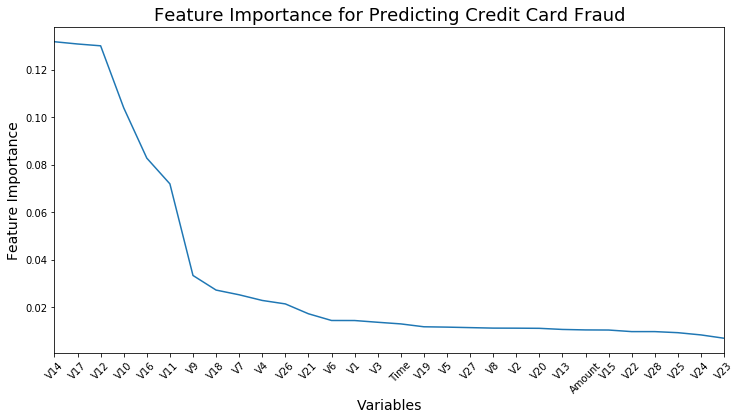

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
pd.Series(feature_importance).sort_values(ascending=False).plot()
ax.set_xticks(range(len(feature_importance)))
ax.set_xticklabels([item for item in feature_importance.sort_values(ascending=False).index.tolist()], rotation=45)
plt.title("Feature Importance for Predicting Credit Card Fraud", size=18)
ax.set_ylabel("Feature Importance", size = 14)
ax.set_xlabel("Variables", size = 14)
plt.show()

V14, V17, V12, V10, V16, V11 and V9 appear to be more useful in predicting the target values


In [28]:
# Let's evaluate the accuracy, precision, and recall scores of the random forest model
y_pred = rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print("Accuracy Score for the rf model is: {}".format(rf_accuracy))
print("Precision Score for the rf model is: {}".format(rf_precision))
print("Recall Score for the rf model is: {}".format(rf_recall))

Accuracy Score for the rf model is: 0.999403110845827
Precision Score for the rf model is: 0.9295774647887324
Recall Score for the rf model is: 0.6947368421052632


In [32]:
rf_weighted = RandomForestClassifier(random_state = 0, class_weight = {0:1, 1:fraud_weight}, n_jobs = -1)
rf_weighted.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 694.6512195121951},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [33]:
y_pred = rf_weighted.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print("Accuracy Score for the rf_weighted model is: {}".format(rf_accuracy))
print("Precision Score for the rf_weighted model is: {}".format(rf_precision))
print("Recall Score for the rf_weighted model is: {}".format(rf_recall))

Accuracy Score for the rf_weighted model is: 0.9995259997893332
Precision Score for the rf_weighted model is: 0.9545454545454546
Recall Score for the rf_weighted model is: 0.7850467289719626


By increasing the weighting on the fraud cases, the recall has improved from 69% to 78%. The precision has also increased

In [116]:
# Right now the Random Forest predicts a case to be fraud if the fraud probability is above 0.5. 
# We can change that threshold to either lower or higher to see how it impacts performances
y_pred_proba = rf_weighted.predict_proba(X_test_scaled)

In [115]:
# Let's create a plot that shows how accuracy, precision, and recall scores change when predict threshold changes
def making_prediction(pred_proba, threshold):
    pred = []
    for p in pred_proba[:,1]:
            if p >= threshold:
                pred.append(1)
            else:
                pred.append(0)
    return np.asarray(pred)

def evaluate_score_distribution(pred_proba, test, model_name, save_fig = False, figname = None): 
    # pred_proba is the result of model.predict_proba
    accuracy_score_dist = {}
    precision_score_dist = {}
    recall_score_dist = {}
    
    threshold_range = np.arange(0, 1 + 0.01, 0.01)
    for threshold in threshold_range:
        pred = making_prediction(pred_proba, threshold) # Use the making_prediction function we just created
        # calculating the metrics for this prediction 
        accuracy = accuracy_score(test, pred)
        precision = precision_score(test, pred)
        recall = recall_score(test, pred)
        
        
        accuracy_score_dist[threshold] = accuracy
        precision_score_dist[threshold] = precision
        recall_score_dist[threshold] = recall
        
        
        
    # Plot the evaluation scores distribution
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(pd.Series(accuracy_score_dist), label="Accuracy Distribution")
    ax.plot(pd.Series(precision_score_dist), label="Precision Distribution")
    ax.plot(pd.Series(recall_score_dist), label="Recall Distribution")
    plt.xticks(threshold_range[::5])
    plt.yticks(np.arange(0, 1 + 0.1, 0.1))
    plt.xlabel("Prediction Probability Threshold", size = 15)
    plt.ylabel("Evaluation Scores", size = 15)
    plt.grid(axis="both")
    plt.legend(loc="lower right")
    plt.title("Evaluation Metrics Distribution ({})".format(model_name), size=18)
    if save_fig == True:
        plt.savefig(figname)
    plt.show()

    
    

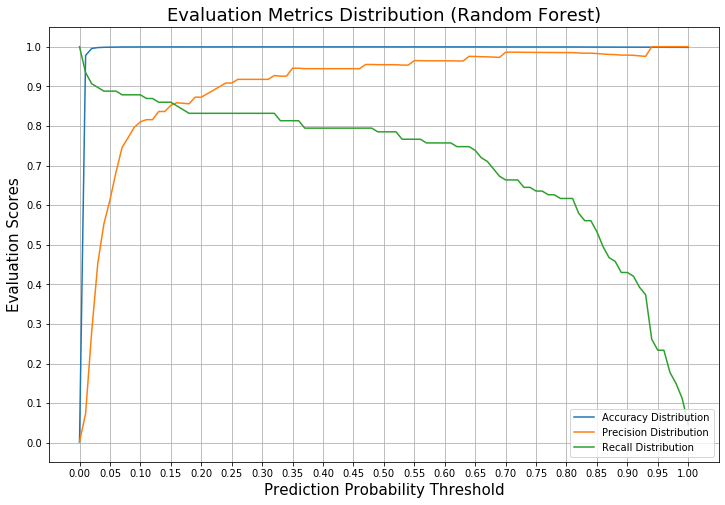

In [114]:
evaluate_score_distribution(y_pred_proba, y_test, "Random Forest", True, "Random_Forest_eval_dist.png")

It seems that if we lower the prediction probability threshold from the default 50 percent to 15 percent, we can achieve much higher recall score while maintaining a precision score of arounf 85%


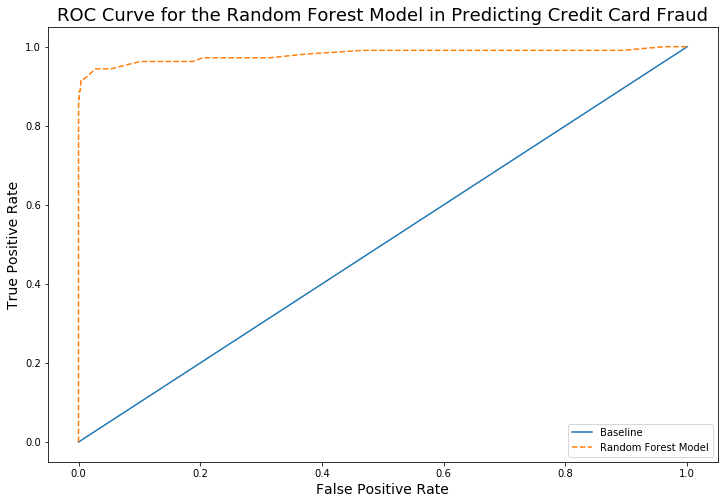

In [109]:
y_score = rf.predict_proba(X_test_scaled)[:, 1]

bl_probs = [0 for a in range(len(y_test))]

bl_fpr, bl_tpr, _ = roc_curve(y_test, bl_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_score)

plt.subplots(figsize = (12, 8))
plt.plot(bl_fpr, bl_tpr, label = "Baseline")
plt.plot(rf_fpr, rf_tpr, linestyle="--", label = "Random Forest Model")
plt.xlabel("False Positive Rate", size=14)
plt.ylabel("True Positive Rate", size=14)
plt.title("ROC Curve for the Random Forest Model in Predicting Credit Card Fraud", size = 18)
plt.legend()
plt.show()



In [110]:
# Let's first see the confusion matrix of the default model with 50 percent prediction threshold
confusion_matrix(y_test, y_pred)

array([[56851,     4],
       [   23,    84]], dtype=int64)

In [119]:
# Let's now see the confusion matrix of the new model with 15 percent prediction threshold
y_pred_15 = making_prediction(y_pred_proba, 0.15)
confusion_matrix(y_test, y_pred_15)

array([[56839,    16],
       [   15,    92]], dtype=int64)

### Now let's try other models to see if they can perform even better

## Let's now look at KNN Model

In [129]:
dt = DecisionTreeClassifier(random_state = 0, class_weight = {0:1, 1:fraud_weight})
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1, 1: 694.6512195121951},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')

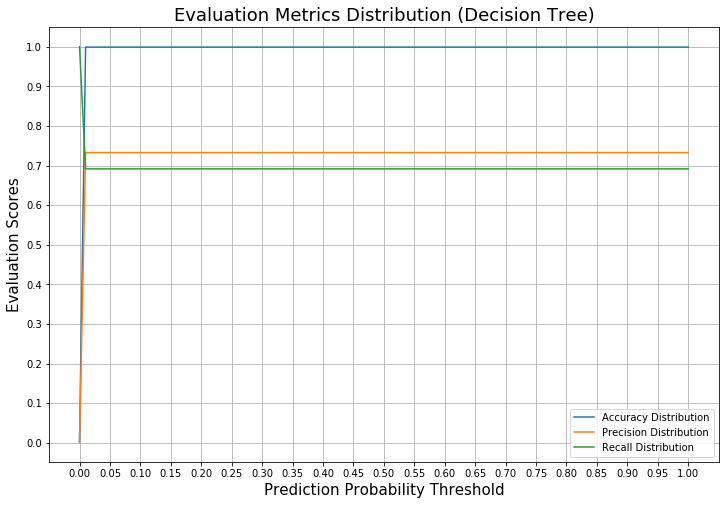

In [130]:
y_pred_proba_dt = dt.predict_proba(X_test_scaled)
evaluate_score_distribution(y_pred_proba_dt, y_test, "Decision Tree")